Copyright (c) 2025 Quan-feng WU <wuquanfeng@ihep.ac.cn>

This notebook is released under the [MIT License](https://opensource.org/licenses/MIT).

# Preliminaries

In [1]:
using DelimitedFiles,
    Statistics

using ArbNumerics,
    DataInterpolations, 
    DifferentialEquations,
    Format,
    ForwardDiff,
    JLD2,
    SpecialFunctions

using NaturalUnits

using CairoMakie,
    LaTeXStrings

In [2]:
set_theme!(theme_latexfonts())
save_plot_flag = false;

In [3]:
include("tool_script-ArbNumerics_compat.jl");
include("tool_script-directories.jl");
include("tool_script-geomspace.jl");
include("tool_script-parameters.jl");

include("tool_script-N_relativistic_species.jl");

include("tool_script-mesons_from_PBH.jl");

In [4]:
γ_PBH = inv(3 * sqrt(3))

N_BH(T_BH) = (27 / 4) * Nᵨ(T_BH) / (30720 * π)
T_BH(m_BH) = NU.M_Pl^2 / m_BH
t_PBH_formation(m_PBH) = m_PBH / (γ_PBH * NU.m_Pl^2)

@info "Utility functions for black hole loaded."

┌ Info: Utility functions for black hole loaded.
└ @ Main /path/to/Primordial-Black-Hole/arXiv-2509.05618/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W5sdnNjb2RlLXJlbW90ZQ==.jl:7


# Standard Big Bang Nucleosynthesis

In [5]:
function evolution_system_SBBN!(du, u, p, η)
    a = exp(η)
    log_Xₙ, log_ρ_SM_in_EU = u

    Xₙ = exp(log_Xₙ)
    ρ_SM = EU(exp(log_ρ_SM_in_EU), 4)

    T_SM = from_ρ_to_T(ρ_SM)

    x = Q / T_SM
    Γₙ_SM = (255 / τ_n) * (12 + 6 * x + x^2) / x^5

    ### Xₙ evolution ##################################
    d_Xₙ_d_t_SM = -Γₙ_SM * (Xₙ - (1 - Xₙ) * exp(-x))
    d_Xₙ_d_t_decay = -Xₙ / τ_n

    d_Xₙ_d_t = d_Xₙ_d_t_SM + d_Xₙ_d_t_decay
    ##################################################

    ### energy density background and Hubble parameter
    H = sqrt(ρ_SM / (3 * NU.M_Pl^2))

    d_ln_N_ρ_d_ln_T = EUval(GeV, T_SM) * ForwardDiff.derivative(T_in_GeV -> (log ∘ Nᵨ)(GeV, T_in_GeV), EUval(GeV, T_SM))
    d_ln_N_s_d_ln_T = EUval(GeV, T_SM) * ForwardDiff.derivative(T_in_GeV -> (log ∘ Nₛ)(GeV, T_in_GeV), EUval(GeV, T_SM))

    d_log_ρ_SM_d_η = -4 + d_ln_N_ρ_d_ln_T / (3 + d_ln_N_s_d_ln_T)
    ##################################################

    du[1] = d_Xₙ_d_t / (H * Xₙ)
    du[2] = d_log_ρ_SM_d_η
    return du
end

evolution_problem_SBBN = ODEProblem(evolution_system_SBBN!,
    map(log ∘ (v -> EUval(EU, v)),
        [inv(1 + exp(Q / GeV(10))), (π^2 / 30) * Nᵨ(GeV(10)) * GeV(10)^4]
    ),
    (0, log(1e7))
)
evolution_solution_SBBN = solve(evolution_problem_SBBN, AutoTsit5(Rosenbrock23()))

a_list_SBBN = geomspace(1, 1e7, 1000)
results_list_SBBN = (evolution_solution_SBBN ∘ log).(a_list_SBBN)
ρ_SM_list_SBBN = map((x -> EU(x, 4)) ∘ exp ∘ last, results_list_SBBN)
T_SM_list_SBBN = from_ρ_to_T.(ρ_SM_list_SBBN)
Xₙ_list_SBBN = (exp ∘ first).(results_list_SBBN)

Yₚ_SBBN = begin
    tmp_perm = sortperm(Q ./ T_SM_list_SBBN)
    Xₙ_T_interpolation_SBBN = LinearInterpolation(Xₙ_list_SBBN[tmp_perm], Q ./ T_SM_list_SBBN[tmp_perm]; extrapolation=ExtrapolationType.Linear, cache_parameters=true)
    Xₙ_nuc_SBBN = Xₙ_T_interpolation_SBBN(Q / T_nuc)
    2 * Xₙ_nuc_SBBN / (1 - Xₙ_nuc_SBBN)
end

@info "SBBN scenario done with Yₚ_SBBN = $Yₚ_SBBN."

┌ Info: SBBN scenario done with Yₚ_SBBN = 0.24499999999999997.
└ @ Main /path/to/Primordial-Black-Hole/arXiv-2509.05618/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X10sdnNjb2RlLXJlbW90ZQ==.jl:55


# Evolution Setup

In [6]:
function evolution_system!(du, u, p, η)
    a = exp(η)
    log_t_in_EU, log_ρ_SM_in_EU, log_m_PBH_in_EU, log_Xₙ,
        log_n_pion_minus_in_EU, log_n_pion_plus_in_EU,
        log_n_kaon_minus_in_EU, log_n_kaon_zero_long_in_EU = u
    a_ini, n_PBH_ini, log_m_PBH_evaporated_in_EU = p

    PBH_evaporated_flag = log_m_PBH_in_EU ≤ log_m_PBH_evaporated_in_EU

    t = EU(exp(log_t_in_EU), -1)
    ρ_SM = EU(exp(log_ρ_SM_in_EU), 4)
    m_PBH = EU(exp(log_m_PBH_in_EU), 1)
    Xₙ = exp(log_Xₙ)
    n_pion_minus = EU(exp(log_n_pion_minus_in_EU < -100 ? -100 : log_n_pion_minus_in_EU), 3)
    n_pion_plus = EU(exp(log_n_pion_plus_in_EU < -100 ? -100 : log_n_pion_plus_in_EU), 3)
    n_kaon_minus = EU(exp(log_n_kaon_minus_in_EU < -100 ? -100 : log_n_kaon_minus_in_EU), 3)
    n_kaon_zero_long = EU(exp(log_n_kaon_zero_long_in_EU < -100 ? -100 : log_n_kaon_zero_long_in_EU), 3)

    n_PBH = PBH_evaporated_flag ? zero(n_PBH_ini) : n_PBH_ini * (a_ini / a)^3
    T_PBH = T_BH(m_PBH)
    T_SM = from_ρ_to_T(ρ_SM)

    n_γ = 2 * ζ₃ * T_SM^3 / π^2
    n_B = η_B * n_γ

    x = Q / T_SM
    ρ_PBH = m_PBH * n_PBH

    N_PBH = N_BH(T_PBH)
    Γₙ_SM = (255 / τ_n) * (12 + 6 * x + x^2) / x^5
    ρ_total = ρ_SM + ρ_PBH

    H = sqrt(ρ_total / (3 * NU.M_Pl^2))
    d_log_t_d_η = inv(H * t)

    d_ln_N_ρ_d_ln_T = EUval(GeV, T_SM) * ForwardDiff.derivative(T_in_GeV -> (log ∘ Nᵨ)(GeV, T_in_GeV), EUval(GeV, T_SM))
    d_ln_N_s_d_ln_T = EUval(GeV, T_SM) * ForwardDiff.derivative(T_in_GeV -> (log ∘ Nₛ)(GeV, T_in_GeV), EUval(GeV, T_SM))

    d_m_PBH_d_t = -N_PBH * NU.m_Pl^4 / m_PBH^2
    PBH_evaporated_flag && (d_m_PBH_d_t = zero(d_m_PBH_d_t))

    d_log_m_PBH_d_η = d_m_PBH_d_t / (H * m_PBH)
    # d_log_ρ_SM_d_η = -4 - d_m_PBH_d_t * n_PBH / (H * ρ_SM)
    d_log_ρ_SM_d_η = -4 + d_ln_N_ρ_d_ln_T / (3 + d_ln_N_s_d_ln_T) - d_m_PBH_d_t * n_PBH / (H * ρ_SM)

    ### Xₙ evolution ##################################
    d_Xₙ_d_t_SM = -Γₙ_SM * (Xₙ - (1 - Xₙ) * exp(-x))
    d_Xₙ_d_t_decay = -Xₙ / τ_n
    d_Xₙ_d_t_pion = (1 - Xₙ) * n_pion_minus * σv_pion_minus_pton(T_SM) - Xₙ * n_pion_plus * σv_pion_plus_ntop(T_SM)
    d_Xₙ_d_t_kaon_minus = (1 - Xₙ) * n_kaon_minus * σv_kaon_minus_pton(T_SM) - Xₙ * n_kaon_minus * σv_kaon_minus_ntop(T_SM)
    d_Xₙ_d_t_kaon_zero_long = (1 - Xₙ) * n_kaon_zero_long * σv_kaon_zero_long_pton(T_SM) - Xₙ * n_kaon_zero_long * σv_kaon_zero_long_ntop(T_SM)

    d_Xₙ_d_t = d_Xₙ_d_t_SM + d_Xₙ_d_t_decay +
                d_Xₙ_d_t_pion + d_Xₙ_d_t_kaon_minus +
                d_Xₙ_d_t_kaon_zero_long

    d_Xₙ_d_η = d_Xₙ_d_t / (H * Xₙ)
    ##################################################

    ### number density of mesons evolution ###########
    d_n_pion_d_t_from_PBH = dN_over_dt_pion(m_PBH) * n_PBH
    d_n_kaon_d_t_from_PBH = dN_over_dt_kaon(m_PBH) * n_PBH
    d_n_kaon_zero_long_d_t_from_PBH = dN_over_dt_kaon_zero_long(m_PBH) * n_PBH

    d_n_pion_minus_d_t = d_n_pion_d_t_from_PBH - Γ_pion_minus * n_pion_minus -
                            σv_pion_minus_pton(T_SM) * (1 - Xₙ) * n_B * n_pion_minus
    d_n_pion_plus_d_t = d_n_pion_d_t_from_PBH - Γ_pion_plus * n_pion_plus -
                            σv_pion_plus_ntop(T_SM) * Xₙ * n_B * n_pion_plus
    d_n_kaon_minus_d_t = d_n_kaon_d_t_from_PBH - Γ_kaon_minus * n_kaon_minus -
                            σv_kaon_minus_pton(T_SM) * (1 - Xₙ) * n_B * n_kaon_minus -
                            σv_kaon_minus_ntop(T_SM) * Xₙ * n_B * n_kaon_minus
    d_n_kaon_zero_long_d_t = d_n_kaon_zero_long_d_t_from_PBH - Γ_kaon_zero_long * n_kaon_zero_long -
                            σv_kaon_zero_long_pton(T_SM) * (1 - Xₙ) * n_B * n_kaon_zero_long -
                            σv_kaon_zero_long_ntop(T_SM) * Xₙ * n_B * n_kaon_zero_long
    ##################################################

    du[1] = d_log_t_d_η
    du[2] = d_log_ρ_SM_d_η
    du[3] = d_log_m_PBH_d_η
    du[4] = d_Xₙ_d_η
    du[5] = iszero(n_pion_minus) ? 0 : d_n_pion_minus_d_t / (H * n_pion_minus)
    du[6] = iszero(n_pion_plus) ? 0 : d_n_pion_plus_d_t / (H * n_pion_plus)
    du[7] = iszero(n_kaon_minus) ? 0 : d_n_kaon_minus_d_t / (H * n_kaon_minus)
    du[8] = iszero(n_kaon_zero_long) ? 0 : d_n_kaon_zero_long_d_t / (H * n_kaon_zero_long)

    return du
end

evolution_system! (generic function with 1 method)

In [7]:
function magic(m_PBH, β_PBH;
    BITS::Int=BITS, log_m_PBH_evaporated_ratio::Number=20, num_points::Int=10000,
    dump_flag::Bool=false, dump_num_points::Int=100,
    mesons_output_flag::Bool=false
)
    dump_flag && @assert dump_num_points <= num_points
    dump_indices = dump_flag ? (Int ∘ round).(1:((num_points - 1) / (dump_num_points - 1)):num_points) : nothing

    a_f = ArbFloat(1; bits=BITS)
    t_f = t_PBH_formation(m_PBH)
    H_f = inv(2 * t_f)
    ρ_SM_f = 3 * NU.M_Pl^2 * H_f^2
    T_SM_f = from_ρ_to_T(ρ_SM_f)
    ρ_PBH_f = β_PBH * ρ_SM_f
    n_PBH_f = ρ_PBH_f / m_PBH
    Xₙ_f = inv(1 + exp(Q / T_SM_f))

    a_end = 10 * cbrt(Nᵨ(T_SM_f) * a_f^3 * T_SM_f^3 / (Nᵨ(T_nuc) * T_nuc^3))

    n_meson_f = 1e-60 * 2 * ζ₃ * T_SM_f^3 / π^2

    # log_m_PBH_evaporated_in_EU = (log ∘ EUval)(EU, m_PBH) - log_m_PBH_evaporated_ratio
    log_m_PBH_evaporated_in_EU = max((log ∘ EUval)(EU, m_PBH) - log_m_PBH_evaporated_ratio, (log ∘ EUval)(EU, NU.m_Pl))

    evolution_problem = ODEProblem(evolution_system!,
        map(log ∘ (v -> EUval(EU, v)),
            [t_f, ρ_SM_f, m_PBH, Xₙ_f, n_meson_f, n_meson_f, n_meson_f, n_meson_f]
        ),
        (log(a_f), log(a_end)),
        (a_f, n_PBH_f, log_m_PBH_evaporated_in_EU)
    )
    evolution_solution = solve(evolution_problem, AutoTsit5(Rosenbrock23()))

    a_list = geomspace(a_f, a_end, num_points)
    results_list = (evolution_solution ∘ log).(a_list)

    t_list = map((v -> EU(v, -1)) ∘ exp ∘ (results -> results[1]), results_list)
    ρ_SM_list = map((v -> EU(v, 4)) ∘ exp ∘ (results -> results[2]), results_list)
    m_PBH_list = map((v -> EU(v, 1)) ∘ exp ∘ (results -> results[3]), results_list)
    n_PBH_list = n_PBH_f .* (a_f ./ a_list).^3
    Xₙ_list = map(exp ∘ (results -> results[4]), results_list)
    n_pion_minus_list = map((v -> EU(v, 3)) ∘ exp ∘ (results -> results[5]), results_list)
    n_pion_plus_list = map((v -> EU(v, 3)) ∘ exp ∘ (results -> results[6]), results_list)
    n_kaon_minus_list = map((v -> EU(v, 3)) ∘ exp ∘ (results -> results[7]), results_list)
    n_kaon_zero_long_list = map((v -> EU(v, 3)) ∘ exp ∘ (results -> results[8]), results_list)

    first_evaporated_index = findfirst(≤(EU(exp(log_m_PBH_evaporated_in_EU), 1)), m_PBH_list)
    isnothing(first_evaporated_index) || for ii ∈ first_evaporated_index:length(n_PBH_list)
        n_PBH_list[ii] = zero(n_PBH_list[ii])
    end

    # ρ_PBH_list = m_PBH_list .* n_PBH_list
    T_SM_list = from_ρ_to_T.(ρ_SM_list)

    # ρ_γ_list = (π^2 / 30) * 2 * T_SM_list.^4

    # ρ_total_list = ρ_SM_list + ρ_PBH_list

    Yₚ = begin
        tmp_perm = sortperm(Q ./ T_SM_list)
        Xₙ_T_interpolation_SBBN = LinearInterpolation(Xₙ_list[tmp_perm], Q ./ T_SM_list[tmp_perm]; extrapolation=ExtrapolationType.Linear, cache_parameters=true)
        Xₙ_nuc = Xₙ_T_interpolation_SBBN(Q / T_nuc)
        2 * Xₙ_nuc / (1 - Xₙ_nuc)
    end

    dump_flag && jldopen(joinpath(dump_data_directory, "dump_$(cfmt("%.2e", m_PBH / NU.g))gram_beta$(cfmt("%.2e", β_PBH)).jld2"), "w+") do io
        write(io, "a_list", Float64.(a_list[dump_indices]))
        write(io, "t_list [sec]", Float64.(t_list[dump_indices] ./ NU.s))
        write(io, "ρ_SM_list [GeV^4]", (Float64 ∘ EUval).(GeV, ρ_SM_list[dump_indices]))
        write(io, "m_PBH_list [gram]", Float64.(m_PBH_list[dump_indices] ./ NU.g))
        write(io, "n_PBH_list [cm^-3]", Float64.(n_PBH_list[dump_indices] .* (1e-2 * NU.m)^3))
        write(io, "Xₙ_list", Float64.(Xₙ_list[dump_indices]))
        write(io, "T_SM_list [GeV]", (Float64 ∘ EUval).(GeV, T_SM_list[dump_indices]))
        write(io, "Yₚ", Float64(Yₚ))
        if mesons_output_flag
            write(io, "n_pion_minus_list [cm^-3]", Float64.(n_pion_minus_list[dump_indices] .* (1e-2 * NU.m)^3))
            write(io, "n_pion_plus_list [cm^-3]", Float64.(n_pion_plus_list[dump_indices] .* (1e-2 * NU.m)^3))
            write(io, "n_kaon_minus_list [cm^-3]", Float64.(n_kaon_minus_list[dump_indices] .* (1e-2 * NU.m)^3))
            write(io, "n_kaon_zero_long_list [cm^-3]", Float64.(n_kaon_zero_long_list[dump_indices] .* (1e-2 * NU.m)^3))
        end
    end

    mesons_output_flag &&
        return a_list, t_list, ρ_SM_list, m_PBH_list, n_PBH_list, Xₙ_list, Yₚ,
               n_pion_minus_list, n_pion_plus_list, n_kaon_minus_list, n_kaon_zero_long_list

    return a_list, t_list, ρ_SM_list, m_PBH_list, n_PBH_list, Xₙ_list, Yₚ
end

magic (generic function with 1 method)

# Benchmarks

In [8]:
# ii, jj = 51, 4
# m_PBH = m_PBH_f_list[ii]
# β_PBH = β_PBH_list[jj]

# m_PBH = 2e9 * NU.g
# β_PBH = 1e-19

m_PBH = 1.56e9 * NU.g
β_PBH = 1e-17
# β_PBH = 4.98e-20

a_list, t_list, ρ_SM_list, m_PBH_list, n_PBH_list, Xₙ_list, Yₚ = magic(m_PBH, β_PBH)

T_SM_list = from_ρ_to_T.(ρ_SM_list)
ρ_PBH_list = m_PBH_list .* n_PBH_list
ρ_total_list = ρ_SM_list + ρ_PBH_list
ρ_γ_list = (π^2 / 30) * 2 * T_SM_list.^4
T_ν_list = T_SM_list .* min.(cbrt.(Nₛ.(T_SM_list) ./ Nₛ(MeV(2))), 1)
ρ_ν_list = π^2 / 30 * (7/8) * 2 * T_ν_list.^4
ρ_PBH_OVER_ρ_ν_ana_list = ((0.040 * β_PBH / 1e-16) * sqrt(1e9 * NU.g / m_PBH)) .* (MeV(2) ./ T_SM_list) .* (T_SM_list ./ T_ν_list).^4 .* (Nₛ.(T_SM_list) ./ Nₛ(MeV(2)))
T_PBH_eva_ana = MeV(1.8) * sqrt((1e9 * NU.g / m_PBH)^3)
ii_eva = findfirst(T -> T_PBH_eva_ana ≥ T, T_SM_list)
for ii ∈ ii_eva:length(ρ_PBH_OVER_ρ_ν_ana_list)
    ρ_PBH_OVER_ρ_ν_ana_list[ii] *= 1e-30
end

ρ_PBH_OVER_ρ_ν_ana_list = ((0.040 * β_PBH / 1e-16) * sqrt(1e9 * NU.g / m_PBH)) .* (MeV(2) ./ T_SM_list) .* (T_SM_list ./ T_ν_list).^4 .* (Nₛ.(T_SM_list) ./ Nₛ(MeV(2)))
T_PBH_eva_ana = MeV(1.8) * sqrt((1e9 * NU.g / m_PBH)^3)
ii_eva = findfirst(T -> T_PBH_eva_ana ≥ T, T_SM_list)
for ii ∈ ii_eva:length(ρ_PBH_OVER_ρ_ν_ana_list)
    ρ_PBH_OVER_ρ_ν_ana_list[ii] *= 1e-30
end

@show last(T_SM_list) < T_nuc

@info """

m_PBH   :   $(m_PBH / NU.g) g
β_PBH   :   $β_PBH
Yₚ      :   $Yₚ
"""

last(T_SM_list) < T_nuc = true


┌ Info: 
│ m_PBH   :   1.56e9 g
│ β_PBH   :   1.0e-17
│ Yₚ      :   0.36995327201691575134940339662207449230328038466421
└ @ Main /path/to/Primordial-Black-Hole/arXiv-2509.05618/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X15sdnNjb2RlLXJlbW90ZQ==.jl:36


# Plots

┌ Info: Scanning data loaded with keys: ["β_PBH_list", "Y_P_mat", "m_PBH_list [gram]", "chi2_mat"].
└ @ Main /path/to/Primordial-Black-Hole/arXiv-2509.05618/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X20sdnNjb2RlLXJlbW90ZQ==.jl:8


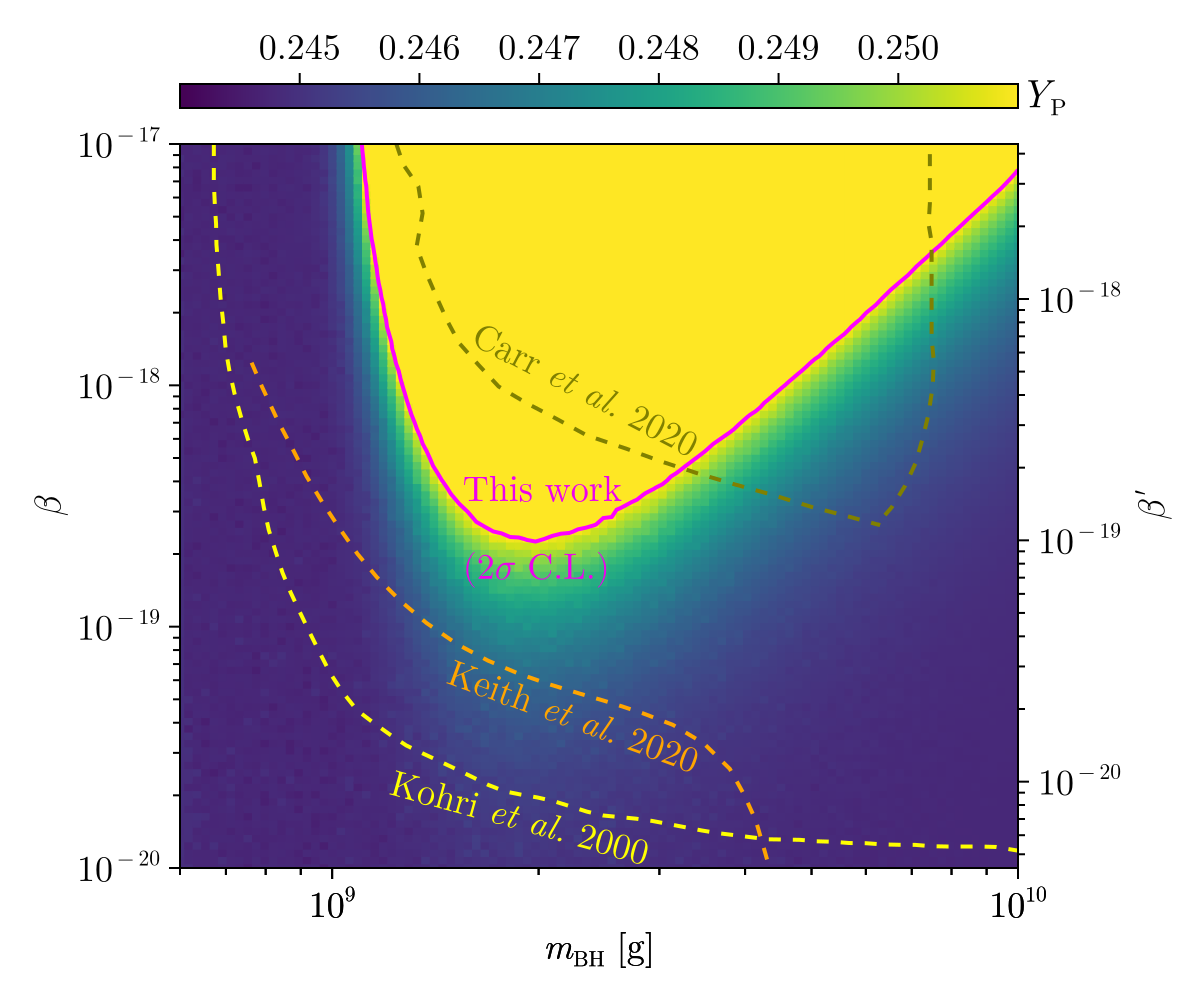

In [9]:
fig_Yₚ = Figure(size=(600, 500), fontsize=18)

scanning_data = load(joinpath(output_data_directory, "scanning.jld2"))
m_PBH_in_gram_list = scanning_data["m_PBH_list [gram]"]
β_PBH_list = scanning_data["β_PBH_list"]
Yₚ_mat = scanning_data["Y_P_mat"]
χ²_mat = scanning_data["chi2_mat"]
@info "Scanning data loaded with keys: $(keys(scanning_data))."

data_Kohri1999ex_Y_P = readdlm(joinpath(external_data_directory, "Kohri1999ex_Y_P.csv"), ',')
data_Carr2010jm_Y_P = readdlm(joinpath(external_data_directory, "Carr2010jm_Y_P.csv"), ',')
data_Keith2020jww_Y_P = readdlm(joinpath(external_data_directory, "Keith2020jww_Y_P.csv"), ',')
data_Carr2020gox_Y_P = readdlm(joinpath(external_data_directory, "Carr2020gox_Y_P.csv"), ',')

axis_general_option = (;
    xlabel=L"$m_\mathrm{BH}$ [g]",
    xscale=log10, yscale=log10,
    xticks=(exp10.(0:20), [L"10^{%$ii}" for ii ∈ 0:20]),
    yticks=(exp10.(-30:0), [L"10^{%$ii}" for ii ∈ -30:0]),
    xminorticks=[cc * exp10(ii) for cc ∈ 2:9, ii ∈ 0:20][:],
    yminorticks=[cc * exp10(ii) for cc ∈ 2:9, ii ∈ -30:0][:],
    xminorticksvisible = true, xminorgridvisible = true,
    yminorticksvisible = true, yminorgridvisible = true
)

ax_β = Axis(fig_Yₚ[2, 1];
    ylabel=L"$\beta$",
    limits=(
        (minimum(m_PBH_in_gram_list), maximum(m_PBH_in_gram_list)),
        (minimum(β_PBH_list), maximum(β_PBH_list))
    ),
    axis_general_option...,
)
ax_βp = Axis(fig_Yₚ[2, 1];
    ylabel=L"$\beta'$",
    yaxisposition = :right,
    limits=(
        (minimum(m_PBH_in_gram_list), maximum(m_PBH_in_gram_list)),
        (minimum(β_PBH_list), maximum(β_PBH_list)) .* sqrt(γ_PBH)
    ),
    axis_general_option...,
)
contour_β = heatmap!(ax_β, m_PBH_in_gram_list, β_PBH_list, Yₚ_mat;
    colorrange=(.245-.001, .245+.006),
    # levels=.245-.001:.0002:.245+.003,
    colormap=:viridis,
    # extendhigh=:yellow,
    # extendlow=RGBf(.2, 0, .2)
)
Colorbar(fig_Yₚ[1, 1], contour_β; ticks=.245-.001:.001:.245+.006, vertical=false)
text!(fig_Yₚ.scene, .85, .88; text=L"$Y_\mathrm{P}$", fontsize=20, space=:relative)
contour!(ax_β, m_PBH_in_gram_list, β_PBH_list, χ²_mat;
    levels=[4],
    color=:magenta,
    # linestyle=:dash,
    linewidth=2
)
lines!(ax_β, data_Kohri1999ex_Y_P[:, 1], data_Kohri1999ex_Y_P[:, 2]; linestyle=:dash, color=:yellow, linewidth=2)
# lines!(ax_βp, data_Carr2010jm_Y_P[:, 1], data_Carr2010jm_Y_P[:, 2]; linestyle=:dash, color=:magenta, linewidth=2)
lines!(ax_βp, data_Keith2020jww_Y_P[:, 1], data_Keith2020jww_Y_P[:, 2]; linestyle=:dash, color=:orange, linewidth=2)
lines!(ax_βp, data_Carr2020gox_Y_P[:, 1], data_Carr2020gox_Y_P[:, 2]; linestyle=:dash, color=:olive, linewidth=2)
# text!(ax_β, 1.5e9, 5e-18; text=L"$Y_\mathrm{P}$ from", color=:red)

text!(ax_β, 1.2e9, 1.9e-20; text=L"Kohri $\textit{et al.}$ 2000", color=:yellow, rotation=-.27)
# text!(ax_β, 2.7e9, 2.5e-19; text=L"Carr $\textit{et al.}$ 2010", color=:magenta, rotation=-.25)
text!(ax_β, 1.45e9, 5.5e-20; text=L"Keith $\textit{et al.}$ 2020", color=:orange, rotation=-.35)
text!(ax_βp, 1.57e9, 6.2e-19; text=L"Carr $\textit{et al.}$ 2020", color=:olive, rotation=-.48)

text!(ax_β, 1.55e9, 3.1e-19; text="This work", color=:magenta2,)
text!(ax_β, 1.55e9, 1.45e-19; text=L"($2 \sigma$ C.L.)", color=:magenta2,)

save_plot_flag && save("plots/Y_P.pdf", fig_Yₚ)
save_plot_flag && save("plots/Y_P.png", fig_Yₚ)
fig_Yₚ

┌ Info: 
│ m_PBH   :   8.0e8 g
│ β_PBH   :   1.0e-18
│ Yₚ      :   0.24491687157810597028708600391673177461480108041795
└ @ Main /path/to/Primordial-Black-Hole/arXiv-2509.05618/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sdnNjb2RlLXJlbW90ZQ==.jl:34
┌ Info: 
│ m_PBH   :   5.0e9 g
│ β_PBH   :   5.0e-19
│ Yₚ      :   0.24734381642448743077629182301510475778311514181861
└ @ Main /path/to/Primordial-Black-Hole/arXiv-2509.05618/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sdnNjb2RlLXJlbW90ZQ==.jl:34
┌ Info: 
│ m_PBH   :   8.0e9 g
│ β_PBH   :   1.0e-19
│ Yₚ      :   0.244912326364582993059082653985220248960212452322
└ @ Main /path/to/Primordial-Black-Hole/arXiv-2509.05618/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X21sdnNjb2RlLXJlbW90ZQ==.jl:34


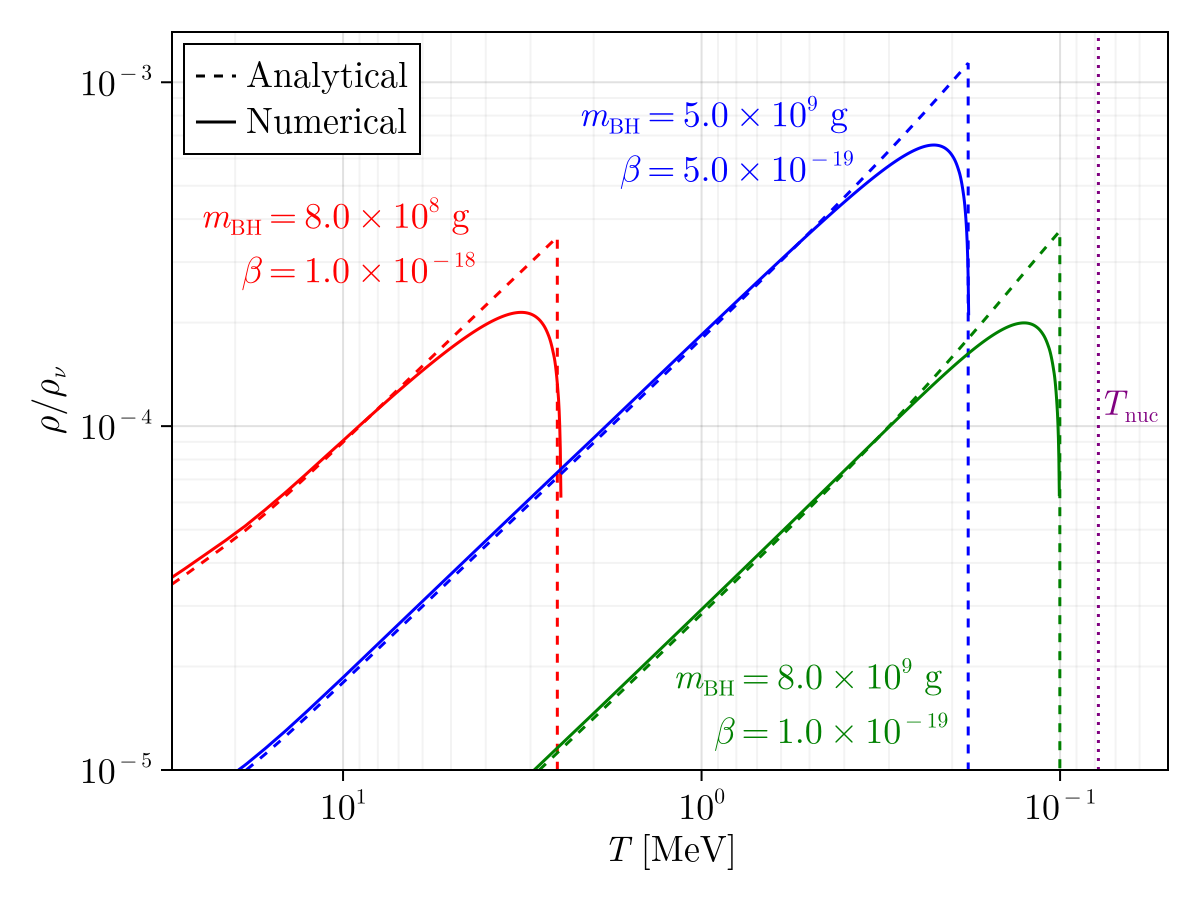

In [10]:
param_list = [
    (m_PBH = 8e8 * NU.g, β_PBH = 1e-18, text_position=(2.5e1, 3.5e-4), color=:red),
    (m_PBH = 5e9 * NU.g, β_PBH = 5e-19, text_position=(2.2e0, 6.9e-4), color=:blue),
    (m_PBH = 8e9 * NU.g, β_PBH = 1e-19, text_position=(1.2e0, 1.6e-5), color=:green),
]
recursion_times = 10
analytical_evaporation_suppression_ratio = 1e-30

fig_evolution_ana_num = Figure(fontsize=18)
ax_evolution_ana_num = Axis(fig_evolution_ana_num[1, 1],
    # title=L"$\rho / \rho_\gamma$ Evolution",
    xlabel=L"$T$ [MeV]", ylabel=L"$\rho / \rho_\nu$",
    xscale=log10, yscale=log10,
    xticks=exp10.(-20:20), xtickformat=vs->[L"10^{%$(Int(log10(v)))}" for v in vs],
    yticks=exp10.(-20:20), ytickformat=vs->[L"10^{%$(Int(log10(v)))}" for v in vs],
    xminorgridvisible=true, xminorticks=IntervalsBetween(9),
    yminorgridvisible=true, yminorticks=IntervalsBetween(9),
    xreversed=true,
    limits=((5e-2, 3e1), (1e-5, 1.4e-3))
    # limits=((1e-2, 1e14), (1e-16, 1e2))
)

for param ∈ param_list
    a_list, t_list, ρ_SM_list, m_PBH_list, n_PBH_list, Xₙ_list, Yₚ = magic(param.m_PBH, param.β_PBH)

    T_SM_list = from_ρ_to_T.(ρ_SM_list)
    ρ_PBH_list = m_PBH_list .* n_PBH_list
    ρ_total_list = ρ_SM_list + ρ_PBH_list
    ρ_γ_list = (π^2 / 30) * 2 * T_SM_list.^4
    T_ν_list = T_SM_list .* min.(cbrt.(Nₛ.(T_SM_list) ./ Nₛ(MeV(2))), 1)
    ρ_ν_list = π^2 / 30 * (7/8) * 2 * T_ν_list.^4

    @assert last(T_SM_list) < T_nuc
    @info """

    m_PBH   :   $(param.m_PBH / NU.g) g
    β_PBH   :   $(param.β_PBH)
    Yₚ      :   $Yₚ
    """

    ρ_PBH_OVER_ρ_ν_ana_list = ((0.040 * param.β_PBH / 1e-16) * sqrt(1e9 * NU.g / param.m_PBH)) .* (MeV(2) ./ T_SM_list) .* (T_SM_list ./ T_ν_list).^4 .* (Nₛ.(T_SM_list) ./ Nₛ(MeV(2)))
    T_PBH_eva_ana = MeV(1.8) * sqrt((1e9 * NU.g / param.m_PBH)^3)
    for ii ∈ 1:recursion_times
        T_PBH_eva_ana = MeV(1.8) * sqrt((1e9 * NU.g / param.m_PBH)^3) * (sqrt ∘ sqrt)(10.75 / Nᵨ(T_PBH_eva_ana))
        # println(ii, ": ", T_PBH_eva_ana)
    end

    evaporated_indices = findall(≤(T_PBH_eva_ana), T_SM_list)
    ρ_PBH_OVER_ρ_ν_ana_list[evaporated_indices] *= analytical_evaporation_suppression_ratio
    ρ_PBH_OVER_ρ_ν_num_list = ρ_PBH_list ./ ρ_ν_list

    T_in_MeV_list = EUval.(MeV, T_SM_list)

    log10_m_PBH_in_g = log10(param.m_PBH / NU.g)
    log10_β_PBH = log10(param.β_PBH)
    m_exponent = (Int ∘ floor)(log10_m_PBH_in_g)
    β_exponent = (Int ∘ floor)(log10_β_PBH)
    m_coefficient = cfmt("%.1f", exp10(log10_m_PBH_in_g - m_exponent))
    β_coefficient = cfmt("%.1f", exp10(log10_β_PBH - β_exponent))

    lines!(ax_evolution_ana_num, T_in_MeV_list, ρ_PBH_OVER_ρ_ν_ana_list; color=param.color, linestyle=:dash)
    lines!(ax_evolution_ana_num, T_in_MeV_list, ρ_PBH_OVER_ρ_ν_num_list; color=param.color, linestyle=:solid)
    text!(ax_evolution_ana_num, param.text_position...; text=L"m_\mathrm{BH} = %$(m_coefficient) \times 10^{%$(m_exponent)} ~ \mathrm{g}", color=param.color)
    text!(ax_evolution_ana_num, param.text_position[1] / 1.3, param.text_position[2] / 1.4; text=L"\beta = %$(β_coefficient) \times 10^{%$(β_exponent)}", color=param.color)
end

lines!(ax_evolution_ana_num, EUval.(MeV, [T_nuc]), [1e-5, 1e-2]; linestyle=:dot, color=:purple)
text!(ax_evolution_ana_num, EUval(MeV, T_nuc), 1e-4; text=L"T_\mathrm{nuc}", color=:purple)

lines!(ax_evolution_ana_num, [1e-1, 1e1], [1e-10]; label="Analytical", color=:black, linestyle=:dash)
lines!(ax_evolution_ana_num, [1e-1, 1e1], [1e-10]; label="Numerical", color=:black, linestyle=:solid)
axislegend(ax_evolution_ana_num; position=:lt)

save_plot_flag && save("plots/energy_density_evolution.pdf", fig_evolution_ana_num)
save_plot_flag && save("plots/energy_density_evolution.png", fig_evolution_ana_num)
fig_evolution_ana_num

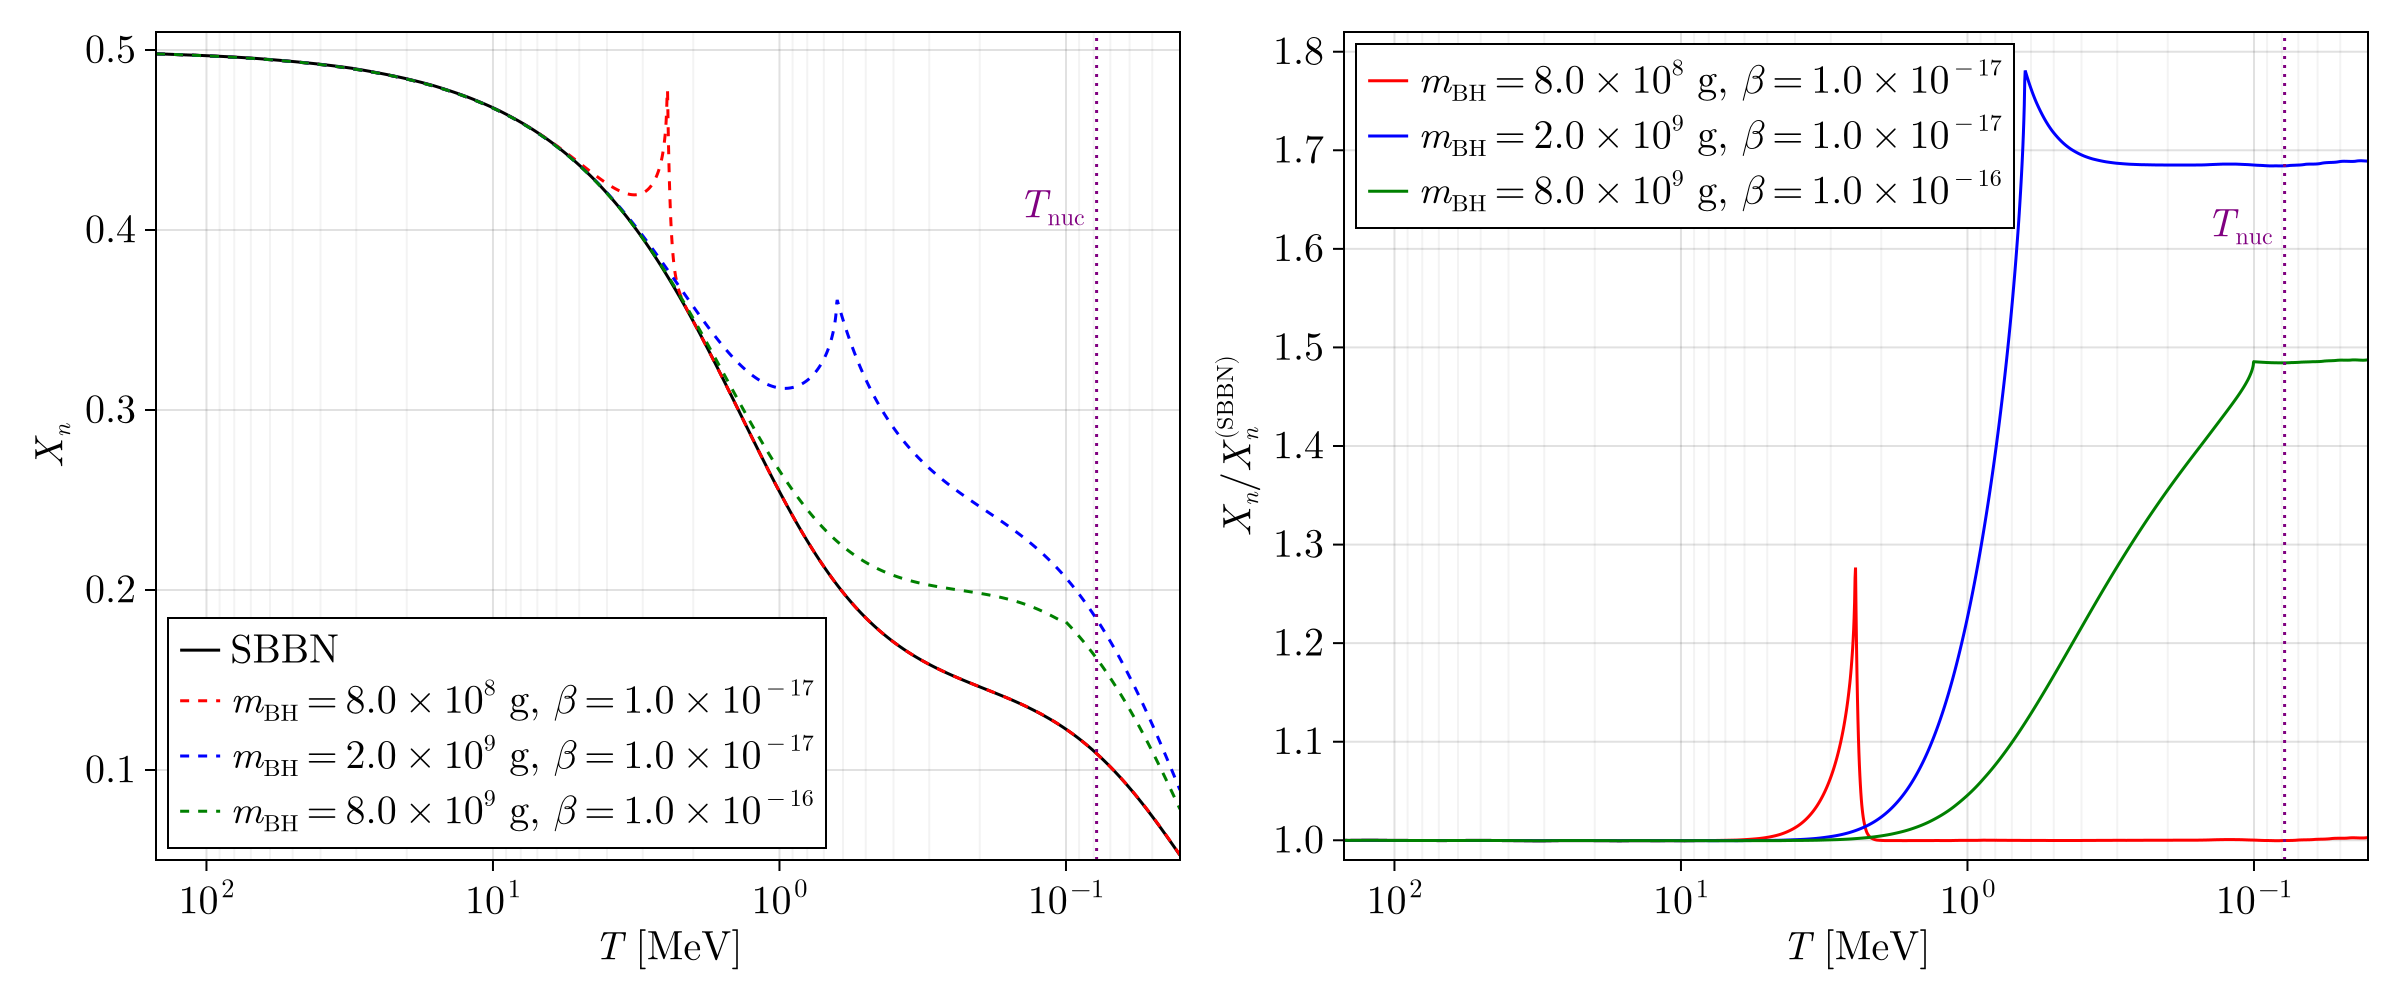

In [11]:
param_list = [
    (m_PBH = 8e8 * NU.g, β_PBH = 1e-17, color=:red),
    (m_PBH = 2e9 * NU.g, β_PBH = 1e-17, color=:blue),
    # (m_PBH = 8e9 * NU.g, β_PBH = 1e-17, color=:green),
    (m_PBH = 8e9 * NU.g, β_PBH = 1e-16, color=:green),
    # (m_PBH = 8e9 * NU.g, β_PBH = 1e-16, color=:chocolate),
]

fig_Xₙ_evolution = Figure(size=(1200, 500), fontsize=20)


ax_Xₙ_evolution = Axis(fig_Xₙ_evolution[1, 1],
    # title=L"$X_n$ Evolution",
    xlabel=L"$T$ [MeV]", ylabel=L"$X_n$",
    xscale=log10, # yscale=log10,
    xreversed=true,
    limits=((4e-2, 1.5e2), (.05, .51)),
    xminorgridvisible=true, xminorticks=IntervalsBetween(9),
    yticks=0:.1:3,
)
ax_Xₙ_ratio_evolution = Axis(fig_Xₙ_evolution[1, 2],
    # title=L"$X_n$ Evolution",
    xlabel=L"$T$ [MeV]", ylabel=L"$X_n / X_n^\mathrm{(SBBN)}$",
    xscale=log10, # yscale=log10,
    xreversed=true,
    limits=((4e-2, 1.5e2), (0.98, 1.82)),
    xminorgridvisible=true, xminorticks=IntervalsBetween(9),
    yticks=0:.1:3,
)

Xₙ_SBBN_interpolation = LinearInterpolation(reverse(Xₙ_list_SBBN), reverse!((log ∘ EUval).(MeV, T_SM_list_SBBN)); extrapolation=ExtrapolationType.Linear, cache_parameters=true)

lines!(ax_Xₙ_evolution, EUval.(MeV, T_SM_list_SBBN), Xₙ_list_SBBN; label="SBBN", color=:black)

for param ∈ param_list
    a_list, t_list, ρ_SM_list, m_PBH_list, n_PBH_list, Xₙ_list, Yₚ = magic(param.m_PBH, param.β_PBH)
    T_SM_list = from_ρ_to_T.(ρ_SM_list)
    Xₙ_list_SBBN_new = (Xₙ_SBBN_interpolation ∘ log ∘ EUval).(MeV, T_SM_list)

    log10_m_PBH_in_g = log10(param.m_PBH / NU.g)
    log10_β_PBH = log10(param.β_PBH)
    m_exponent = (Int ∘ floor)(log10_m_PBH_in_g)
    β_exponent = (Int ∘ floor)(log10_β_PBH)
    m_coefficient = cfmt("%.1f", exp10(log10_m_PBH_in_g - m_exponent))
    β_coefficient = cfmt("%.1f", exp10(log10_β_PBH - β_exponent))

    lines!(ax_Xₙ_evolution, EUval.(MeV, T_SM_list), Xₙ_list;
        color=param.color, linestyle=:dash,
        label=L"m_\mathrm{BH} = %$(m_coefficient) \times 10^{%$(m_exponent)} ~ \mathrm{g}, ~ \beta = %$(β_coefficient) \times 10^{%$(β_exponent)}"
    )

    lines!(ax_Xₙ_ratio_evolution, EUval.(MeV, T_SM_list), Xₙ_list ./ Xₙ_list_SBBN_new;
        color=param.color,
        label=L"m_\mathrm{BH} = %$(m_coefficient) \times 10^{%$(m_exponent)} ~ \mathrm{g}, ~ \beta = %$(β_coefficient) \times 10^{%$(β_exponent)}"
    )
end
lines!(ax_Xₙ_evolution, EUval.(MeV, [T_nuc]), [-1, 2]; linestyle=:dot, color=:purple)
text!(ax_Xₙ_evolution, 1.1 * EUval(MeV, T_nuc), 0.4; text=L"T_\mathrm{nuc}", color=:purple, align=(:right, :bottom))
lines!(ax_Xₙ_ratio_evolution, EUval.(MeV, [T_nuc]), [-1, 2]; linestyle=:dot, color=:purple)
text!(ax_Xₙ_ratio_evolution, 1.1 * EUval(MeV, T_nuc), 1.6; text=L"T_\mathrm{nuc}", color=:purple, align=(:right, :bottom))

axislegend(ax_Xₙ_evolution; position=:lb)
axislegend(ax_Xₙ_ratio_evolution; position=:lt)

save_plot_flag && save("plots/X_n_evolution.pdf", fig_Xₙ_evolution)
save_plot_flag && save("plots/X_n_evolution.png", fig_Xₙ_evolution)
fig_Xₙ_evolution

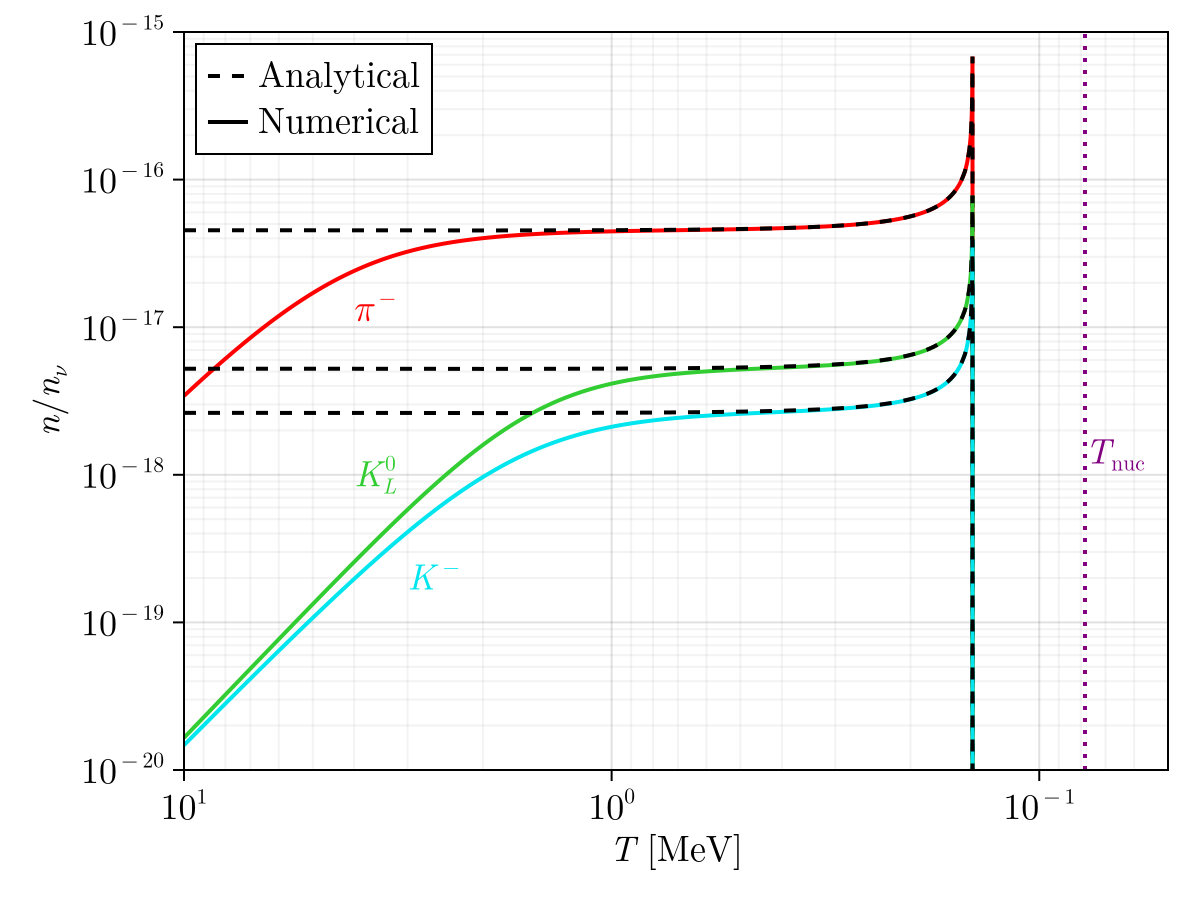

In [12]:
m_PBH = 6e9 * NU.g
β_PBH = 1e-16

a_list, t_list, ρ_SM_list, m_PBH_list, n_PBH_list, Xₙ_list, Yₚ,
    n_pion_minus_list, n_pion_plus_list, n_kaon_minus_list, n_kaon_zero_long_list =
    magic(m_PBH, β_PBH; mesons_output_flag=true)

T_SM_list = from_ρ_to_T.(ρ_SM_list)
T_SM_in_MeV_list = EUval.(MeV, T_SM_list)
T_ν_list = T_SM_list .* min.(cbrt.(Nₛ.(T_SM_list) ./ Nₛ(MeV(2))), 1)
n_ν_in_cm3_list = (ζ₃ / π^2) * 2 * T_ν_list.^3 .* (1e-2 * NU.m)^3
n_pion_minus_in_cm3_list = n_pion_minus_list .* (1e-2 * NU.m)^3
n_pion_plus_in_cm3_list = n_pion_plus_list .* (1e-2 * NU.m)^3
n_kaon_minus_in_cm3_list = n_kaon_minus_list .* (1e-2 * NU.m)^3
n_kaon_zero_long_in_cm3_list = n_kaon_zero_long_list .* (1e-2 * NU.m)^3

vanishing_indices = findall(≤(1e-10), m_PBH_list ./ first(m_PBH_list))
n_pion_minus_in_cm3_list[vanishing_indices] .= 1e-30
n_kaon_minus_in_cm3_list[vanishing_indices] .= 1e-30
n_kaon_zero_long_in_cm3_list[vanishing_indices] .= 1e-30

n_pion_in_cm3_ana_list = n_PBH_list .* dN_over_dt_pion.(m_PBH_list) .* τ_π .* (1e-2 * NU.m)^3
n_pion_in_cm3_ana_list[vanishing_indices] .= 1e-30
n_kaon_minus_in_cm3_ana_list = n_PBH_list .* dN_over_dt_kaon.(m_PBH_list) .* inv(Γ_kaon_minus) .* (1e-2 * NU.m)^3
n_kaon_minus_in_cm3_ana_list[vanishing_indices] .= 1e-30
n_kaon_zero_long_in_cm3_ana_list = n_PBH_list .* dN_over_dt_kaon_zero_long.(m_PBH_list) .* inv(Γ_kaon_zero_long) .* (1e-2 * NU.m)^3
n_kaon_zero_long_in_cm3_ana_list[vanishing_indices] .= 1e-30

fig_meson_evolution = Figure(fontsize=18)
ax_meson_evolution = Axis(fig_meson_evolution[1, 1],
    # title="Meson Evolution",
    xlabel=L"$T$ [MeV]", ylabel=L"n / n_\nu",
    xscale=log10, yscale=log10,
    xreversed=true,
    limits=((5e-2, 1e1), (1e-20, 1e-15)),
    xticks=exp10.(-100:100), xtickformat=vs->[L"10^{%$(Int(log10(v)))}" for v in vs],
    yticks=exp10.(-100:100), ytickformat=vs->[L"10^{%$(Int(log10(v)))}" for v in vs],
    xminorgridvisible=true, xminorticks=IntervalsBetween(9),
    yminorgridvisible=true, yminorticks=IntervalsBetween(9),
)

lines!(ax_meson_evolution, T_SM_in_MeV_list, n_pion_minus_in_cm3_list ./ n_ν_in_cm3_list; color=:red, linewidth=2)
# lines!(ax_meson_evolution, T_SM_in_MeV_list, n_pion_plus_in_cm3_list ./ n_ν_in_cm3_list; color=:orange, linewidth=2)
lines!(ax_meson_evolution, T_SM_in_MeV_list, n_pion_in_cm3_ana_list ./ n_ν_in_cm3_list; color=:black, linestyle=:dash, linewidth=2)
text!(ax_meson_evolution, 4e0, 1e-17; text=L"\pi^-", color=:red)
# text!(ax_meson_evolution, 7e0, 2e-17; text=L"\pi^+", color=:orange)

lines!(ax_meson_evolution, T_SM_in_MeV_list, n_kaon_zero_long_in_cm3_list ./ n_ν_in_cm3_list; color=:limegreen, linewidth=2)
lines!(ax_meson_evolution, T_SM_in_MeV_list, n_kaon_zero_long_in_cm3_ana_list ./ n_ν_in_cm3_list; color=:black, linestyle=:dash, linewidth=2)
text!(ax_meson_evolution, 4e0, 7e-19; text=L"K^0_L", color=:limegreen)

lines!(ax_meson_evolution, T_SM_in_MeV_list, n_kaon_minus_in_cm3_list ./ n_ν_in_cm3_list; color=:turquoise2, linewidth=2)
lines!(ax_meson_evolution, T_SM_in_MeV_list, n_kaon_minus_in_cm3_ana_list ./ n_ν_in_cm3_list; color=:black, linestyle=:dash, linewidth=2)
text!(ax_meson_evolution, 3e0, 1.5e-19; text=L"K^-", color=:turquoise2)

lines!(ax_meson_evolution, EUval.(MeV, [T_nuc]), [1e-30, 1e100]; linestyle=:dot, color=:purple, linewidth=2)
text!(ax_meson_evolution, EUval(MeV, T_nuc), 1e-18; text=L"T_\mathrm{nuc}", color=:purple)

lines!(ax_meson_evolution, [1e-5, 1e5], [1e-30]; linestyle=:dash, color=:black, label="Analytical", linewidth=2)
lines!(ax_meson_evolution, [1e-5, 1e5], [1e-30]; linestyle=:solid, color=:black, label="Numerical", linewidth=2)
axislegend(ax_meson_evolution; position=:lt)

save_plot_flag && save("plots/meson_evolution_M$(cfmt("%.2e", m_PBH / NU.g))gram_β$(cfmt("%.2e", β_PBH)).pdf", fig_meson_evolution)
save_plot_flag && save("plots/meson_evolution_M$(cfmt("%.2e", m_PBH / NU.g))gram_β$(cfmt("%.2e", β_PBH)).png", fig_meson_evolution)
fig_meson_evolution